# Lab03: Cây quyết định

**Cách làm bài**


- Làm trực tiếp vào notebook.
- Làm những phần có chữ `TODO`.


**Nội dung:**

- Cây quyết định.
- Naive Bayes

### Import thư viện

In [5]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

### Tải bộ dữ liệu Iris

In [6]:
from sklearn.model_selection import train_test_split
iris=datasets.load_iris()

X=iris.data
y=iris.target

#split dataset into training data and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33, random_state=42)

## 1. Cây quyết định: Iterative Dichotomiser 3 (ID3)

### 1.1 Độ lợi thông tin

Giá trị kỳ vọng của self-information (entropy):

$$Entropy=-\sum_{i}^{n}p_ilog_{2}(p_i)$$

Hàm entropy đạt giá trị nhỏ nhất nếu có giá trị $p_i$ bằng 1, đạt giá trị lớn nhất nếu tất cả $p_i$ đều bằng nhau. Những tính chất này của hàm entropy làm cho nó là một biểu hiện của sự mất trật tự, hay tính ngẫu nhiên của một hệ thống, ...

In [7]:
def entropy(counts, n_samples):
    """
    Parameters:
    -----------
    counts: shape (n_classes): list number of samples in each class
    n_samples: number of data samples
    
    -----------
    return entropy 
    """
    #TODO
    res = 0
    for i in range(len(counts)):
      res -= (counts[i]*1.0/n_samples) * np.log2(counts[i]*1.0/n_samples)
    return res


In [8]:
def entropy_of_one_division(division): 
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    n_samples = len(division)
    n_classes = set(division)
    
    counts=[]
    #count samples in each class then store it to list counts
    #TODO:
    for samples in n_classes:
      counts.append(np.sum(samples==division))
    
    return entropy(counts,n_samples),n_samples


def get_entropy(y_predict, y):
    """
    Returns entropy of a split
    y_predict is the split decision by cutoff, True/Fasle
    """
    n = len(y)
    entropy_true, n_true = entropy_of_one_division(y[y_predict]) # left hand side entropy
    entropy_false, n_false = entropy_of_one_division(y[~y_predict]) # right hand side entropy
    # overall entropy
    #TODO s=?
    s = n_true * 1/n * entropy_true + n_false * 1/n * entropy_false
    return s

Độ lợi thông tin của việc phân loại tập thông tin D theo thuộc tính A:
$$ Gain(A)=Entrophy(D)-Entrophy_{A}(D)$$

Tại mỗi nút trong ID3, một thuộc tính được chọn nếu mức tăng thông tin của nó cao nhất so với các nút khác.

Tất cả các thuộc tính của bộ dữ liệu Iris được biểu diễn bằng các giá trị liên tục. Do đó chúng ta cần biểu diễn chúng bằng các giá trị rời rạc. Một cách đơn giản là sử dụng ngưỡng `cutoff` để tách các giá trị của dữ liệu trên mỗi thuộc tính thành hai phần: ` <cutoff` và `> = cutoff`.

Để tìm `cutoff` tốt nhất cho một thuộc tính, chúng ta thay thế `cutoff` bằng các giá trị của nó rồi tính toán entropy, `cutoff` tốt nhất đạt được khi giá trị của entropy nhỏ nhất $ \left (\arg \min Entrophy_ {A} (D) \right) $.

### 1.2 Cây quyết định

In [9]:
class DecisionTreeClassifier:
    def __init__(self, tree=None, depth=0):
        '''Parameters:
        -----------------
        tree: decision tree
        depth: depth of decision tree after training'''
        
        self.depth = depth
        self.tree=tree
    def fit(self, X, y, node={}, depth=0):
        '''Parameter:
        -----------------
        X: training data
        y: label of training data
        ------------------
        return: node 
        
        node: each node represented by cutoff value and column index, value and children.
         - cutoff value is thresold where you divide your attribute
         - column index is your data attribute index
         - value of node is mean value of label indexes, 
           if a node is leaf all data samples will have same label
        
        Note that: we divide each attribute into 2 part => each node will have 2 children: left, right.
        '''
        
        #Stop conditions
        
        #if all value of y are the same 
        if np.all(y==y[0]):
            return {'val':y[0]}

        else: 
            col_idx, cutoff, entropy = self.find_best_split_of_all(X, y)    # find one split given an information gain 
            y_left = y[X[:, col_idx] < cutoff]
            y_right = y[X[:, col_idx] >= cutoff]
            node = {'index_col':col_idx,
                        'cutoff':cutoff,
                   'val':np.mean(y)}
            node['left'] = self.fit(X[X[:, col_idx] < cutoff], y_left, {}, depth+1)
            node['right'] = self.fit(X[X[:, col_idx] >= cutoff], y_right, {}, depth+1)
            self.depth += 1 
            self.tree = node
            return node
    
    def find_best_split_of_all(self, X, y):
        col_idx = None
        min_entropy = 1
        cutoff = None
        for i, col_data in enumerate(X.T):
            entropy, cur_cutoff = self.find_best_split(col_data, y)
            if entropy == 0:                   #best entropy
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:
                min_entropy = entropy
                col_idx = i
                cutoff = cur_cutoff
               
        return col_idx, cutoff, min_entropy
    
    def find_best_split(self, col_data, y):
        ''' Parameters:
        -------------
        col_data: data samples in column'''
         
        min_entropy = 10

        #Loop through col_data find cutoff where entropy is minimum
        
        for value in set(col_data):
            y_predict = col_data < value
            my_entropy = get_entropy(y_predict, y)
            #TODO
            #min entropy=?, cutoff=?
            if min_entropy > my_entropy:
              min_entropy = my_entropy
              cutoff = value
        return min_entropy, cutoff
                                               
    def predict(self, X):
        tree = self.tree
        pred = np.zeros(shape=len(X))
        for i, c in enumerate(X):
            pred[i] = self._predict(c)
        return pred
    
    def _predict(self, row):
        cur_layer = self.tree
        while cur_layer.get('cutoff'):
            if row[cur_layer['index_col']] < cur_layer['cutoff']:
                cur_layer = cur_layer['left']
            else:
                cur_layer = cur_layer['right']
        else:
            return cur_layer.get('val')

### 1.3 Phân loại trên Bộ dữ liệu Iris

In [10]:
model = DecisionTreeClassifier()
tree = model.fit(X_train, y_train)
pred=model.predict(X_train)
print('Accuracy of your decision tree model on training data:', accuracy_score(y_train,pred))
pred=model.predict(X_test)
print('Accuracy of your decision tree model:', accuracy_score(y_test,pred))


Accuracy of your decision tree model on training data: 1.0
Accuracy of your decision tree model: 0.96


## 2. Định lý Bayes

Công thức Bayes
$$\begin{equation}
P\left(A|B\right)= \dfrac{P\left(B|A\right)P\left(A\right)}{P\left(B\right)}
\end{equation}$$

Nếu $B$ là dữ liệu của chúng ta thì $\mathcal{D}$, $A$ và $w$ là các tham số mà chúng ta cần ước tính:

$$ \begin{align}
    \underbrace{P(w|\mathcal{D})}_{Posterior}= \dfrac{1}{\underbrace{P(\mathcal{D})}_{Normalization}} \overbrace{P(\mathcal{D}|w)}^{\text{Likelihood}} \overbrace{P(w)}^{Prior}
    \end{align}
$$

#### Naive Bayes
Để đơn giản hóa, người ta thường giả định rằng các thành phần của biến ngẫu nhiên $D$ (hoặc các features của dữ liệu $D$) là độc lập với nhau, nếu $w$ được biết. Nghĩa là:
$$P(\mathcal{D}|w)=\prod _{i=1}^{d}P(x_i|w)$$

- $d$: số lượng features



### 2.1. Hàm mật độ xác suất

In [11]:
class pdf:
    def __init__(self,hist=None):
        '''
        A probability density function represented by a histogram
        
        hist: shape (n,1), n: number of hypotheses
        hypo: hypothesis (simply understand as label)
        ------------------
        hist[hypo]=P(hypo)
        '''
        self.hist = hist
        
    #virtual function
    def likelihood(self, data, hypo):
        '''Paramters:
        data: new data record 
        hypo: hypothesis (simply understand as label)
        ---------
        return P(data/hypo)
        ''' 
        raise Exception()
            
    #update histogram for new data 
    def update(self, data):
        ''' 
        P(hypo/data)=P(data/hypo)*P(hypo)*(1/P(data))
        '''
        
        #Likelihood * Prior 
        #TODO
        for hypo in self.hist.keys():
            #self.hist[hypo]=?
            self.hist[hypo] *= self.likelihood(data, hypo)
            
            
        #Normalization
        
        #TODO: s=P(data)
        #s=?
        s=0
        for hypo in self.hist.keys():
          s += self.hist[hypo]
        for hypo in self.hist.keys():
            self.hist[hypo] = self.hist[hypo]/s
        
    def plot_pdf(self):
        #plot Histogram
        #TODO
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        x = list(self.hist.keys())
        y = list(self.hist.values())
        ax.bar(x, y)
        plt.show()
    
    def maxHypo(self):
        #find the hypothesis with maximum probability from hist
        #TODO
        max_prob = list(self.hist.keys())[0]
        for hypo_max_prob in self.hist.keys():
          if self.hist[max_prob] < self.hist[hypo_max_prob]: max_prob = hypo_max_prob
        return max_prob



### 2.2 Phân loại trên Bộ dữ liệu Iris

#### Gaussian Naive Bayes

- Naive Bayes có thể được mở rộng để sử dụng trên dữ liệu liên tục, phổ biến nhất là bằng cách sử dụng phân phối chuẩn (phân phối Gaussian).

- Phần mở rộng này được gọi là Gaussian Naive Bayes. Các hàm khác có thể được sử dụng để ước tính phân phối dữ liệu, nhưng Gauss (hoặc phân phối chuẩn) là dễ làm việc nhất vì chúng ta chỉ cần ước tính giá trị trung bình và độ lệch chuẩn từ dữ liệu huấn luyện.

#### Định nghĩa hàm Gauss

$$ f\left(x;\mu,\sigma \right)= \dfrac{1}{\sigma \sqrt{2\pi}} 
\exp \left({-\dfrac{\left(x-\mu\right)^2}{2 \sigma^2}}\right) $$

In [12]:
def Gauss(std,mean,x):
    #Compute the Gaussian probability distribution function for x
    #TODO 
    gaussian = (1/(std*np.sqrt(2*np.pi))) * np.exp(-((x-mean)**2/(2*(std**2))))
    return gaussian


In [13]:
class NBGaussian(pdf):
    def __init__(self, hist=None, std=None, mean=None):
        '''Parameters:
        
        '''
        pdf.__init__(self, hist)
        self.std=std
        self.mean=mean
    def likelihood(self,data, hypo):
        '''
        Returns: res=P(data/hypo)
        -----------------
        Naive bayes:
            Atributes are assumed to be conditionally independent given the class value.
        '''
    
        std=self.std[hypo]
        mean=self.mean[hypo]
        res=1
        #TODO
        #res=res*P(x1/hypo)*P(x2/hypo)...
        for i in range(len(data)):
          res *= Gauss(std[i], mean[i], data[i])
        return res 
    def fit(self, X,y):
        """Parameters:
        X: training data
        y: labels of training data
        """
        n=len(X)
        #number of iris species
        #TODO
        #n_species=???
        n_species = len(set(y))

        
        hist={}
        mean={}
        std={}
        
        #separate  dataset into rows by class
        for hypo in range(0,n_species):
            #rows have hypo label
            #TODO rows=
            rows = []
            for i in range(n):
              feature_values = X[i]
              class_name = y[i]
              hypo_label = y[hypo]
              if class_name == hypo_label: rows.append(feature_values)
            #histogram for each hypo
            #TODO probability=?
            propability = len(rows) / n
            hist[hypo]=propability
            
            #Each hypothesis represented by its mean and standard derivation
            '''mean and standard derivation should be calculated for each column (or each attribute)'''
            #TODO mean[hypo]=?, std[hypo]=?
            mean[hypo] = np.mean(X[y==hypo], axis=0)
            std[hypo] = np.std(X[y==hypo], axis=0)
         
        self.mean=mean
        self.std=std
        self.hist=hist
   
    def _predict(self, data, plot=False):
        """
        Predict label for only 1 data sample
        ------------
        Parameters:
        data: data sample
        plot: True: draw histogram after update new record
        -----------
        return: label of data
        """
        model=NBGaussian(hist=self.hist.copy(),std=self.std.copy(), mean=self.mean.copy())
        model.update(data)
        if (plot): model.plot_pdf()
        return model.maxHypo()
    
    def predict(self, data):
        """Parameters:
        Data: test data
        ----------
        return labels of test data"""
        
        pred=[]
        for x in data:
            pred.append(self._predict(x))
        return pred

#### Hiển thị histogram của dữ liệu huấn luyện

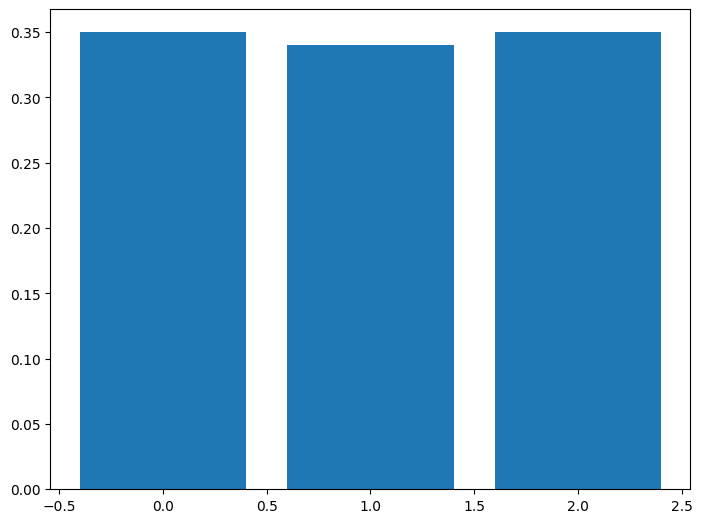

In [14]:
model_1=NBGaussian()
model_1.fit(X_train, y_train)
model_1.plot_pdf()

#### Kiểm tra với 1 data record

Label of X_test[10]:  2
Our histogram after update X_test[10]: 


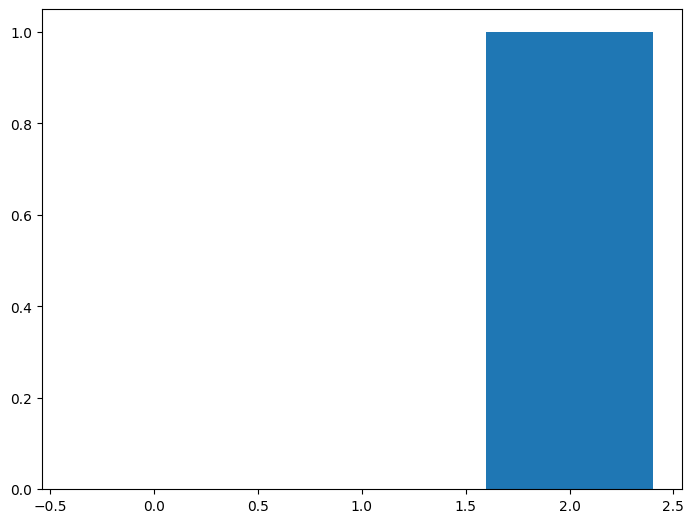

2

In [15]:
#label of y_test[10]
print('Label of X_test[10]: ', y_test[10])
#update model and show histogram with X_test[10]:

print('Our histogram after update X_test[10]: ')
model_1._predict(X_test[10],plot=True)


#### Đánh giá mô hình Gaussian Naive Bayes của bạn

In [16]:
pred=model_1.predict(X_test)
print('Accuracy of your Gaussian Naive Bayes model:', accuracy_score(y_test,pred))

Accuracy of your Gaussian Naive Bayes model: 0.96


**TODO**: Báo cáo về F1, Recall và Precision.

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.93      0.93      0.93        15
           2       0.94      0.94      0.94        16

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

